In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation


%matplotlib inline

# 1. Data Collection from defaulted loan

In [105]:
appended_data = []
#change here to switch between before crisis and after crisis
years = list(map(str, range(2003, 2009)))
quarters = [ 'Q1', 'Q2', 'Q3', 'Q4']
for year in years: 
    for quarter in quarters:
        data2 = pd.read_csv("../Data_files/"+ year + quarter +".csv")
        print(year + quarter, data2.shape)
        appended_data.append(data2)
        
data = pd.concat(appended_data)
    
# Some basic formating  
data.reset_index(inplace = True)
data.drop('index', axis=1, inplace=True)

2003Q1 (17364, 67)
2003Q2 (23921, 67)


C:\Users\prith\AppData\Local\Temp\ipykernel_23824\2666492242.py:7: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv("../Data_files/"+ year + quarter +".csv")


2003Q3 (27929, 67)
2003Q4 (17857, 67)
2004Q1 (12137, 67)
2004Q2 (16300, 67)
2004Q3 (12402, 67)
2004Q4 (14121, 67)
2005Q1 (12887, 67)
2005Q2 (17228, 67)


C:\Users\prith\AppData\Local\Temp\ipykernel_23824\2666492242.py:7: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv("../Data_files/"+ year + quarter +".csv")


2005Q3 (26075, 67)
2005Q4 (25542, 67)
2006Q1 (19104, 67)
2006Q2 (23000, 67)
2006Q3 (21439, 67)
2006Q4 (23838, 67)
2007Q1 (21592, 67)


C:\Users\prith\AppData\Local\Temp\ipykernel_23824\2666492242.py:7: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv("../Data_files/"+ year + quarter +".csv")


2007Q2 (24627, 67)
2007Q3 (26399, 67)
2007Q4 (38510, 67)
2008Q1 (28258, 67)
2008Q2 (24050, 67)
2008Q3 (17103, 67)
2008Q4 (10973, 67)


In [106]:
# Removing all columns which contain more than 90% null values
null_count = data.isnull().sum()
null_columns = null_count[null_count > data.shape[0]*(0.9)]
print(null_columns)
remove_columns = list(set(null_columns.index) - set(['CURR_RATE', 'NON_INTEREST_BEARING_UPB']))
data.drop(remove_columns , axis=1, inplace=True)

SERVICER                                  502656
CURR_RATE                                 492727
LOAN_AGE                                  502656
REM_MONTHS                                502656
ADJ_REM_MONTHS                            502656
MATR_DT                                   502656
PMT_HISTORY                               502656
MOD_FLAG                                  493693
TOT_SCHD_PRNCPL                           492800
NON_INTEREST_BEARING_UPB                  496958
PRINCIPAL_FORGIVENESS_AMOUNT              496900
SERV_IND                                  502656
FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT    496640
FORBEARANCE_INDICATOR                     492720
ADR_TYPE                                  492720
ADR_COUNT                                 502299
ADR_UPB                                   502301
dtype: int64


In [107]:
date_cols = ['ORIG_DATE', 'LAST_PAID_INSTALLMENT_DATE', 'FORECLOSURE_DATE', 'DISPOSITION_DATE', 'FIRST_PAY', 'ZB_DTE']
for date_col in date_cols:
    print(date_col)
    #data[date_col] = data[date_col].astype('Int64').astype(str)
    data[date_col+'_m'] =  pd.to_numeric(data[date_col].astype('Int64').astype(str).str[:-4], errors='coerce')
    data[date_col+'_y'] =  pd.to_numeric(data[date_col].astype('Int64').astype(str).str[-4:], errors='coerce') 
    
# dropping the original date columns at the end of macroeconomic variables integration in Model_A2

ORIG_DATE
LAST_PAID_INSTALLMENT_DATE
FORECLOSURE_DATE
DISPOSITION_DATE
FIRST_PAY
ZB_DTE


In [108]:
date_colsF= ['ORIG_DATE_m', 'ORIG_DATE_y', 'LAST_PAID_INSTALLMENT_DATE_m',
       'LAST_PAID_INSTALLMENT_DATE_y', 'FORECLOSURE_DATE_m',
       'FORECLOSURE_DATE_y', 'DISPOSITION_DATE_m', 'DISPOSITION_DATE_y', 
      'FIRST_PAY_m', 'FIRST_PAY_y', 'ZB_DTE_m', 'ZB_DTE_y']

for dt_col in date_colsF:
    data[dt_col] = data[dt_col].astype('Int64')

In [109]:
# the columns CURR_RATE and NON_INTEREST_BEARING_UPB have high null value

#The NON_INTEREST_BEARING_UPB can be made zero for Nan value
#Substitute CURR_RATE with Origination_rate
#Substituting Disposition_date with Zero_balance_effective_date
data['NON_INTEREST_BEARING_UPB'] = data['NON_INTEREST_BEARING_UPB'].fillna(0)
data['DISPOSITION_DATE_y'] = data['DISPOSITION_DATE_y'].fillna(data['FORECLOSURE_DATE_y'])

In [110]:
data['ACCRUED_INT'] =  (data['DISPOSITION_DATE_y'] * 12 + data['DISPOSITION_DATE_m']- \
                    data['LAST_PAID_INSTALLMENT_DATE_y'] * 12 - data['LAST_PAID_INSTALLMENT_DATE_m']) * \
                    (((data['ORIG_RATE'] / 100) - 0.0035) / 12) * (data['LAST_UPB'] - data['NON_INTEREST_BEARING_UPB'])
data['ACCRUED_INT'] = data['ACCRUED_INT'].fillna(0)
data['ACCRUED_INT'] = data['ACCRUED_INT'].apply(lambda x: x if x > 0 else 0)

In [111]:
#Loss calculation
loss_calculation_cols = ['LAST_UPB', 'FORECLOSURE_COSTS', 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS', 'ASSET_RECOVERY_COSTS', 
               'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS', 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
     'NET_SALES_PROCEEDS', 'CREDIT_ENHANCEMENT_PROCEEDS', 'OTHER_FORECLOSURE_PROCEEDS']
data[loss_calculation_cols].isnull().sum()

LAST_UPB                                           0
FORECLOSURE_COSTS                               9220
PROPERTY_PRESERVATION_AND_REPAIR_COSTS         57524
ASSET_RECOVERY_COSTS                          105885
MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS     28300
ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY          36916
NET_SALES_PROCEEDS                              8808
CREDIT_ENHANCEMENT_PROCEEDS                   152626
OTHER_FORECLOSURE_PROCEEDS                    104780
dtype: int64

In [112]:
#Visualising last unpaid balance column
data['LAST_UPB'].describe()

count    502656.000000
mean     161424.140698
std       92325.559017
min           0.000000
25%       89573.010000
50%      144405.210000
75%      216399.502500
max      877348.120000
Name: LAST_UPB, dtype: float64

In [113]:
# We are not considering the data having loss up to $100
data = data[data['LAST_UPB']> 100.0]

for col in loss_calculation_cols:
    data[col].fillna(0, inplace=True)
    
data['LOSS'] = (data['LAST_UPB'] \
               +data['FORECLOSURE_COSTS']  \
               +data['PROPERTY_PRESERVATION_AND_REPAIR_COSTS'] \
               +data['ASSET_RECOVERY_COSTS']  \
               +data['MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS']  \
               +data['ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY']  \
                +data['ACCRUED_INT'] \
               -data['NET_SALES_PROCEEDS']  \
               -data['CREDIT_ENHANCEMENT_PROCEEDS'] \
               -data['OTHER_FORECLOSURE_PROCEEDS'])
data['LOSS'] = data['LOSS'].round(2)

<AxesSubplot:>

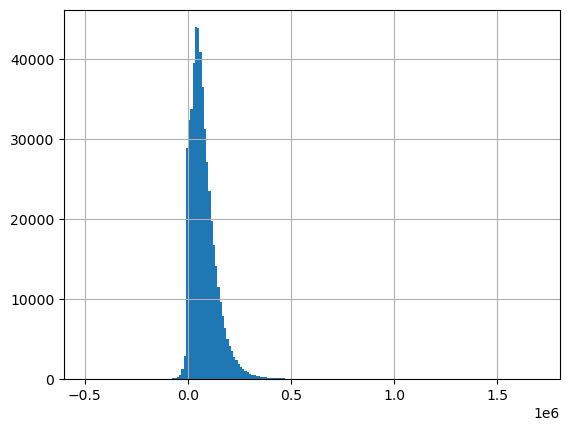

In [114]:
data['LOSS'].hist(bins=200)

# 2. integrate the macroeconomic & state wise variables

In [115]:
FHA30yr_data = pd.read_csv("./MacroEconomicToMerge/FHA30YearRate.csv")
FHA30yr_data.drop("DATE", axis = 1, inplace=True)

Unemployment_data = pd.read_csv("./MacroEconomicToMerge/UnemploymentRate.csv", index_col=0)

State_HPI = pd.read_csv("./MacroEconomicToMerge/State_HPI.csv", index_col=0)
State_HPI2 = pd.read_csv("./MacroEconomicToMerge/State_HPI.csv", index_col=0)

State_HPI = State_HPI.rename(columns = {'DATE' : 'ORIG_DATE', 'HPI' : 'Orig_HPI', 'State' : 'STATE'})
State_HPI2 = State_HPI2.rename(columns = {'DATE' : 'DISPOSITION_DATE', 'HPI' : 'Disp_HPI', 'State' : 'STATE'})


In [116]:
data = data.merge(FHA30yr_data, on = 'ZB_DTE', how='left')

Unemployment_data = Unemployment_data.rename({'DATE': 'ZB_DTE'}, axis = 1)
data = data.merge(Unemployment_data, on = 'ZB_DTE', how='left')

data = data.merge(State_HPI, on = ['ORIG_DATE', 'STATE'], how='left')
data = data.merge(State_HPI2, on = ['DISPOSITION_DATE', 'STATE'], how='left')


In [117]:
data['MTM_LTV'] = data['LAST_UPB']/(data['ORIG_UPB']/data['OLTV']/data['Orig_HPI']*data['Disp_HPI'])


In [138]:
data['MTM_LTV']

0         46.585631
1         57.555854
2         84.417459
3         62.443259
4         46.494219
            ...    
502615    92.150509
502616    87.742573
502617    71.963301
502618    98.159220
502619    70.150645
Name: MTM_LTV, Length: 502620, dtype: float64

In [118]:
#calculating Loann age
data['Loan_age'] = data['DISPOSITION_DATE_y'] + data['DISPOSITION_DATE_m']/12 - (data['ORIG_DATE_y'] + data['ORIG_DATE_m']/12 )

In [119]:
from MacroEconomicToMerge.state_foreclosure import method_of_foreclosure_and_time

method_of_foreclosure_and_time = pd.DataFrame(method_of_foreclosure_and_time, columns=['STATE', 'method_of_foreclosurer', 'time_to_foreclose'])

data = data.merge(method_of_foreclosure_and_time, on = 'STATE', how='left')

In [120]:
#removing the unrequired date  columns here
data.drop(date_cols, axis= 1, inplace=True)

In [121]:
# Comment the first line after running this, Uncomment the second line for regaining checkpoint
#data_check = data.copy(deep=True)
#data = data_check.copy()

# 3. Final data formatting and selection of columns as predictors

In [122]:
data.rename({'HIGH_BALANCE_LOAN_INDICATOR': 'HIGH_BAl',
             'method_of_foreclosurer' : 'method_fore',
             'FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT': 'principal_writeoff'
            }, axis=1, inplace=True)

In [123]:
data = pd.get_dummies(data, columns=['PURPOSE', 'HIGH_BAl', 'method_fore', 'Zero_Bal_Code'], drop_first=True)

In [124]:
# ID is a non-predictor column, SELLER is too-much varialble right now
# State column has been used by macroeconomic variable- method_of_foreclosurer
unwanted_cols = set(loss_calculation_cols + ['LOAN_ID', 'SELLER', 'STATE']) - set(['LAST_UPB'])

#new variable for data declared
wdata = data.drop(unwanted_cols, axis = 1)

In [125]:
# max amount of data we can loose = 10%
max_loose = 0.1

nulls_final = wdata.isnull().sum(axis = 0)
tobe_removed = nulls_final[nulls_final > data.shape[0]*max_loose]
print(tobe_removed)
wdata.drop(list(tobe_removed.index), axis=1, inplace=True)

CURR_RATE                          492712
CSCORE_C                           336562
MI_PCT                             350215
IO                                  80323
REPURCHASES_MAKE_WHOLE_PROCEEDS    188860
MI_TYPE                            350215
dtype: int64


<AxesSubplot:>

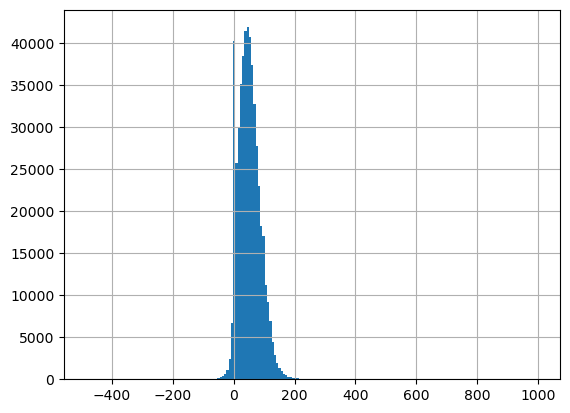

In [126]:
wdata['Lossper_GD'] = (wdata['LOSS']/wdata['LAST_UPB'])*100
wdata[(wdata['Lossper_GD']>-500) & (wdata['Lossper_GD']<1000)]['Lossper_GD'].hist(bins=200)

In [127]:
#wdata.to_csv('../CleanData.csv')

# OLS

In [128]:
from math import log
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import random

random.seed(10)
from pyearth import Earth

In [129]:
# important before starting regression
wdata.dropna(0, inplace=True)
print(wdata.shape)

C:\Users\prith\AppData\Local\Temp\ipykernel_23824\4233065074.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  wdata.dropna(0, inplace=True)


(475757, 57)


In [130]:
wdata.columns

Index(['ACT_PERIOD', 'CHANNEL', 'ORIG_RATE', 'ORIG_UPB', 'CURRENT_UPB',
       'ORIG_TERM', 'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FIRST_FLAG',
       'PROP', 'NO_UNITS', 'OCC_STAT', 'MSA', 'ZIP', 'PRODUCT', 'PPMT_FLG',
       'DLQ_STATUS', 'LAST_UPB', 'NON_INTEREST_BEARING_UPB',
       'HOMEREADY_PROGRAM_INDICATOR', 'RELOCATION_MORTGAGE_INDICATOR',
       'HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR', 'RE_PROCS_FLAG',
       'ORIG_DATE_m', 'ORIG_DATE_y', 'LAST_PAID_INSTALLMENT_DATE_m',
       'LAST_PAID_INSTALLMENT_DATE_y', 'FORECLOSURE_DATE_m',
       'FORECLOSURE_DATE_y', 'DISPOSITION_DATE_m', 'DISPOSITION_DATE_y',
       'FIRST_PAY_m', 'FIRST_PAY_y', 'ZB_DTE_m', 'ZB_DTE_y', 'ACCRUED_INT',
       'LOSS', 'FHA_Mean', 'UNEmpRate', 'Orig_HPI', 'Disp_HPI', 'MTM_LTV',
       'Loan_age', 'time_to_foreclose', 'PURPOSE_P', 'PURPOSE_R', 'PURPOSE_U',
       'method_fore_Judicial', 'method_fore_Power-of-Sale',
       'method_fore_Strict Foreclosure', 'Zero_Bal_Code_3.0',
       

LOSS/LGD Prediction

In [131]:
# Doing a random split now, 
#can be converted into time based split later

#outliers filtering 
sdata = wdata[(wdata['Lossper_GD']>-200) & (wdata['Lossper_GD']<400)]

train, evaluate = train_test_split(sdata, test_size=0.2)

In [132]:
#switch here between LOSS and Lossper_GD
output = 'Lossper_GD'

# loan age
# zero balance one hot -encoded

predictors= ['ORIG_RATE',  'ORIG_TERM', 'ORIG_UPB','LAST_UPB', 'OLTV', 'CSCORE_B','ORIG_DATE_m', 'ORIG_DATE_y',
           'UNEmpRate', 'time_to_foreclose', 'PURPOSE_P',
       'PURPOSE_R', 'method_fore_Judicial', 'OCLTV', 'Disp_HPI', 'FHA_Mean', 'Orig_HPI', 'UNEmpRate', 'MTM_LTV',
       'method_fore_Power-of-Sale', 'method_fore_Strict Foreclosure',
       'LAST_PAID_INSTALLMENT_DATE_m', 'LAST_PAID_INSTALLMENT_DATE_y',
       'FORECLOSURE_DATE_m', 'FORECLOSURE_DATE_y', 'DISPOSITION_DATE_m',
       'DISPOSITION_DATE_y', 'Zero_Bal_Code_3.0','Zero_Bal_Code_9.0', 'Zero_Bal_Code_15.0',]

Y_train = train[output]
#'HIGH_BAl_Y' - May not be present because it has unique value
X_train = train[predictors]

Y_eval = evaluate[output]
X_eval = evaluate[predictors]

In [133]:
# calculate aic for regression
def calculate_aic(n, mse, num_params):
 aic = n * log(mse) + 2 * num_params
 return aic
# calculate bic for regression
def calculate_bic(n, mse, num_params):
 bic = n * log(mse) + num_params * log(n)
 return bic

In [134]:
X_train_ = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train_.astype(float))
results = model.fit()

In [135]:
#publish these
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Lossper_GD   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     8196.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:02:16   Log-Likelihood:            -1.8081e+06
No. Observations:              380480   AIC:                         3.616e+06
Df Residuals:                  380450   BIC:                         3.617e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -2149.0721     86.529    -24.836      0.000   -2318.666   -1979.478
ORIG_RATE                         10.6071      0.104    102.146      0.000      10.404      10.811
ORIG_TERM                         -0.0463      0.001    -40.487      0.000      -0.049      -0.044
ORIG_UPB                          -0.0002   3.66e-06    -60.850      0.000      -0.000      -0.000
LAST_UPB                           0.0001   3.79e-06     26.404      0.000    9.26e-05       0.000
OLTV                              -0.2754      0.012    -22.089      0.000      -0.300      -0.251
CSCORE_B                           0.0074      0.001      8.645      0.000       0.006       0.009
ORIG_DATE_m                       -0.1846      0.014    -13.249      0.000      -0.212      -0.157
ORIG_DATE_y                       -1.0988      0.037    -29.665      0.000      -1.171      -1.026
UNEmpRate                          1.1513      0.018     64.489      0.000       1.116       1.186
time_to_foreclose                  0.0040      0.000     15.765      0.000       0.004       0.005
PURPOSE_P                        -10.3220      0.121    -85.153      0.000     -10.560     -10.084
PURPOSE_R                         -2.0091      0.120    -16.679      0.000      -2.245      -1.773
method_fore_Judicial               0.8978      0.748      1.200      0.230      -0.568       2.364
OCLTV                              0.1691      0.011     15.354      0.000       0.147       0.191
Disp_HPI                          -0.0903      0.001    -61.234      0.000      -0.093      -0.087
FHA_Mean                           4.2247      0.095     44.289      0.000       4.038       4.412
Orig_HPI                           0.0930      0.001     72.744      0.000       0.091       0.096
UNEmpRate                          1.1513      0.018     64.489      0.000       1.116       1.186
MTM_LTV                            0.1592      0.005     29.356      0.000       0.149       0.170
method_fore_Power-of-Sale         -2.7553      0.759     -3.631      0.000      -4.242      -1.268
method_fore_Strict Foreclosure    -0.0637      0.865     -0.074      0.941      -1.758       1.631
LAST_PAID_INSTALLMENT_DATE_m      -0.6674      0.014    -47.944      0.000      -0.695      -0.640
LAST_PAID_INSTALLMENT_DATE_y      -7.9497      0.043   -185.955      0.000      -8.033      -7.866
FORECLOSURE_DATE_m                -0.3566      0.017    -20.511      0.000      -0.391      -0.323
FORECLOSURE_DATE_y                -3.9199      0.123    -31.789      0.000      -4.162      -3.678
DISPOSITION_DATE_m                 1.1003      0.017     65.606      0.000       1.067       1.133
DISPOSITION_DATE_y                14.0043      0.113    124.469      0.000      13.784      14.225
Zero_Bal_Code_

In [136]:
# Sklearn learning and predictions on evaluation set
OLreg = LinearRegression()
OLreg.fit(X_train, Y_train)

LinearRegression()

In [137]:
Y_pred = OLreg.predict(X_eval)
print("R^2 :", r2_score(Y_eval, Y_pred))
mse = mean_squared_error(Y_eval, Y_pred)
print("AIC", calculate_aic(Y_eval.shape[0], mse, len(predictors)))

R^2 : 0.38577653965644143
AIC 632884.5315295832


In [296]:
# Sklearn Pyearth learning and predictions 
OLsplines = Earth(max_terms = 200)
OLsplines.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


KeyboardInterrupt: 

In [256]:
#Print the model
print(OLsplines.trace())
print(OLsplines.summary())

Forward Pass
-----------------------------------------------------------------------
iter  parent  var  knot    mse          terms  gcv       rsq    grsq   
-----------------------------------------------------------------------
0     -       -    -       1337.967046  1      1337.974  0.000  0.000  
1     0       27   -1      1250.098835  2      1250.122  0.066  0.066  
2     0       0    225070  1185.239160  4      1185.292  0.114  0.114  
3     0       18   -1      1142.519200  5      1142.585  0.146  0.146  
4     0       17   378661  1109.305921  7      1109.399  0.171  0.171  
5     0       2    131038  1058.432660  9      1058.549  0.209  0.209  
6     0       3    -1      1008.229450  10     1008.354  0.246  0.246  
7     0       25   -1      977.069053   11     977.203   0.270  0.270  
8     0       21   -1      885.417235   12     885.550   0.338  0.338  
9     0       9    -1      867.117608   13     867.259   0.352  0.352  
10    0       17   303292  856.066482   15     856.

In [262]:
Y_pred = OLsplines.predict(X_eval)
print("R^2 :", r2_score(Y_eval, Y_pred))

R^2 : 0.3947232083807727
